# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np

import cv2
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes
    
#     BACKBONE = "resnet50"

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

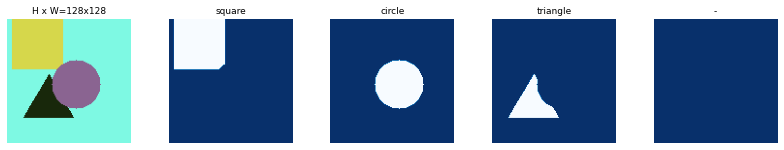

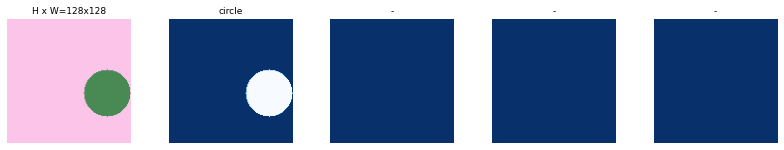

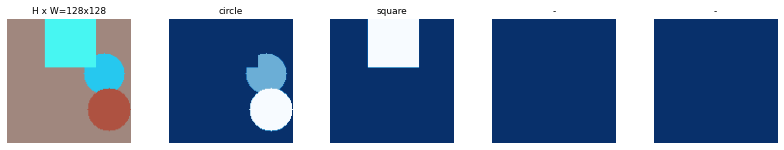

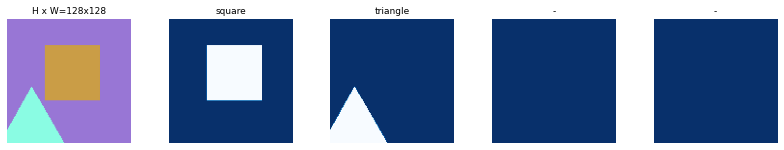

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [25]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [26]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [27]:
# # Train the head branches
# # Passing layers="heads" freezes all layers except the head
# # layers. You can also pass a regular expression to select
# # which layers to train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=1, 
#             layers='heads')

In [28]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=500, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/omkar/ArteryProj/Mask_RCNN_TF2_USound/logs/shapes20220801T2047/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

Epoch 21/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.3029 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2963 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.3133 - mrcnn_mask_loss: 0.4088 - val_loss: 1.1858 - val_rpn_class_loss: 0.0203 - val_rpn_bbox_loss: 0.2583 - val_mrcnn_class_loss: 0.2443 - val_mrcnn_bbox_loss: 0.2722 - val_mrcnn_mask_loss: 0.3906
Epoch 22/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.2746 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.4068 - val_loss: 1.6398 - val_rpn_class_loss: 0.0146 - val_rpn_bbox_loss: 0.4280 - val_mrcnn_class_loss: 0.3178 - val_mrcnn_bbox_loss: 0.3866 - val_mrcnn_mask_loss: 0.4929
Epoch 23/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.2470 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2918 - mrcnn

Epoch 41/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.8186 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1671 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.2000 - mrcnn_mask_loss: 0.2936 - val_loss: 1.1549 - val_rpn_class_loss: 0.0156 - val_rpn_bbox_loss: 0.3357 - val_mrcnn_class_loss: 0.2276 - val_mrcnn_bbox_loss: 0.2772 - val_mrcnn_mask_loss: 0.2988
Epoch 42/500
100/100 [==============================] - 17s 172ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.8347 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3037 - val_loss: 0.8494 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.2535 - val_mrcnn_class_loss: 0.1889 - val_mrcnn_bbox_loss: 0.1770 - val_mrcnn_mask_loss: 0.2205
Epoch 43/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.8401 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1782 - mrcnn

Epoch 61/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.6222 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2379 - val_loss: 0.9176 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.4388 - val_mrcnn_class_loss: 0.0742 - val_mrcnn_bbox_loss: 0.2061 - val_mrcnn_mask_loss: 0.1820
Epoch 62/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.6667 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.2521 - val_loss: 0.8670 - val_rpn_class_loss: 0.0145 - val_rpn_bbox_loss: 0.2483 - val_mrcnn_class_loss: 0.1017 - val_mrcnn_bbox_loss: 0.2543 - val_mrcnn_mask_loss: 0.2482
Epoch 63/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5691 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1029 - mrcnn

Epoch 81/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4654 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.2059 - val_loss: 1.0493 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.3093 - val_mrcnn_class_loss: 0.1335 - val_mrcnn_bbox_loss: 0.2159 - val_mrcnn_mask_loss: 0.3825
Epoch 82/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5100 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.2091 - val_loss: 0.6421 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 0.1991 - val_mrcnn_class_loss: 0.1324 - val_mrcnn_bbox_loss: 0.1282 - val_mrcnn_mask_loss: 0.1762
Epoch 83/500
100/100 [==============================] - 17s 172ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4420 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0675 - mrcnn

Epoch 101/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.6922 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.2292 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2147 - val_loss: 0.6606 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.2564 - val_mrcnn_class_loss: 0.1352 - val_mrcnn_bbox_loss: 0.1150 - val_mrcnn_mask_loss: 0.1452
Epoch 102/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.6685 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2128 - val_loss: 0.7142 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.2424 - val_mrcnn_class_loss: 0.1411 - val_mrcnn_bbox_loss: 0.1531 - val_mrcnn_mask_loss: 0.1670
Epoch 103/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5743 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0672 - mr

Epoch 121/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5490 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.1949 - val_loss: 0.7584 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.1863 - val_mrcnn_class_loss: 0.2304 - val_mrcnn_bbox_loss: 0.1667 - val_mrcnn_mask_loss: 0.1656
Epoch 122/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5802 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.1938 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1857 - val_loss: 0.6817 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.2495 - val_mrcnn_class_loss: 0.1518 - val_mrcnn_bbox_loss: 0.1437 - val_mrcnn_mask_loss: 0.1299
Epoch 123/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4962 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0552 - mr

Epoch 141/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4525 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1651 - val_loss: 1.0316 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.3790 - val_mrcnn_class_loss: 0.3472 - val_mrcnn_bbox_loss: 0.1276 - val_mrcnn_mask_loss: 0.1664
Epoch 142/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4521 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1668 - val_loss: 0.9249 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.1842 - val_mrcnn_class_loss: 0.2804 - val_mrcnn_bbox_loss: 0.1948 - val_mrcnn_mask_loss: 0.2570
Epoch 143/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4041 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0439 - mr

Epoch 161/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3900 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1367 - val_loss: 0.6945 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.2564 - val_mrcnn_class_loss: 0.1981 - val_mrcnn_bbox_loss: 0.1307 - val_mrcnn_mask_loss: 0.0981
Epoch 162/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3941 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1482 - val_loss: 0.5834 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.2065 - val_mrcnn_class_loss: 0.1889 - val_mrcnn_bbox_loss: 0.0902 - val_mrcnn_mask_loss: 0.0908
Epoch 163/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3943 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0368 - mr

Epoch 181/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3690 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1523 - val_loss: 0.6995 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.2593 - val_mrcnn_class_loss: 0.2061 - val_mrcnn_bbox_loss: 0.0968 - val_mrcnn_mask_loss: 0.1303
Epoch 182/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3588 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1498 - val_loss: 0.7084 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.1621 - val_mrcnn_class_loss: 0.1874 - val_mrcnn_bbox_loss: 0.1415 - val_mrcnn_mask_loss: 0.2103
Epoch 183/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3643 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0310 - mr

Epoch 201/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3196 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1312 - val_loss: 0.7531 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.1764 - val_mrcnn_class_loss: 0.2496 - val_mrcnn_bbox_loss: 0.1656 - val_mrcnn_mask_loss: 0.1517
Epoch 202/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3725 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0244 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1516 - val_loss: 0.4727 - val_rpn_class_loss: 0.0064 - val_rpn_bbox_loss: 0.2051 - val_mrcnn_class_loss: 0.0828 - val_mrcnn_bbox_loss: 0.0926 - val_mrcnn_mask_loss: 0.0859
Epoch 203/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3542 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0229 - mr

Epoch 221/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2938 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1340 - val_loss: 0.3933 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.0992 - val_mrcnn_class_loss: 0.1215 - val_mrcnn_bbox_loss: 0.0872 - val_mrcnn_mask_loss: 0.0813
Epoch 222/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3065 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1312 - val_loss: 0.9982 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.2380 - val_mrcnn_class_loss: 0.1976 - val_mrcnn_bbox_loss: 0.1640 - val_mrcnn_mask_loss: 0.3904
Epoch 223/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3190 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0196 - mr

Epoch 241/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2929 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1264 - val_loss: 0.9498 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.2353 - val_mrcnn_class_loss: 0.3735 - val_mrcnn_bbox_loss: 0.1400 - val_mrcnn_mask_loss: 0.1944
Epoch 242/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2963 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1243 - val_loss: 0.7867 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.3088 - val_mrcnn_class_loss: 0.2280 - val_mrcnn_bbox_loss: 0.1091 - val_mrcnn_mask_loss: 0.1348
Epoch 243/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3289 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0265 - mr

Epoch 261/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2518 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1157 - val_loss: 1.0888 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.2529 - val_mrcnn_class_loss: 0.2974 - val_mrcnn_bbox_loss: 0.1515 - val_mrcnn_mask_loss: 0.3785
Epoch 262/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2673 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1100 - val_loss: 0.4891 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.1983 - val_mrcnn_class_loss: 0.0869 - val_mrcnn_bbox_loss: 0.1027 - val_mrcnn_mask_loss: 0.0916
Epoch 263/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2744 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0176 - mr

Epoch 281/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2399 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1118 - val_loss: 1.2340 - val_rpn_class_loss: 0.0054 - val_rpn_bbox_loss: 0.2987 - val_mrcnn_class_loss: 0.2599 - val_mrcnn_bbox_loss: 0.2548 - val_mrcnn_mask_loss: 0.4153
Epoch 282/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2514 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1151 - val_loss: 0.9027 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.3164 - val_mrcnn_class_loss: 0.2999 - val_mrcnn_bbox_loss: 0.1321 - val_mrcnn_mask_loss: 0.1447
Epoch 283/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2842 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0159 - mr

Epoch 301/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2367 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1108 - val_loss: 0.9782 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.2697 - val_mrcnn_class_loss: 0.2670 - val_mrcnn_bbox_loss: 0.1499 - val_mrcnn_mask_loss: 0.2843
Epoch 302/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2272 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1035 - val_loss: 0.9652 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.2638 - val_mrcnn_class_loss: 0.4226 - val_mrcnn_bbox_loss: 0.1301 - val_mrcnn_mask_loss: 0.1397
Epoch 303/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2497 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mr

Epoch 321/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2273 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1084 - val_loss: 0.5201 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.1968 - val_mrcnn_class_loss: 0.1232 - val_mrcnn_bbox_loss: 0.0763 - val_mrcnn_mask_loss: 0.1154
Epoch 322/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2167 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0992 - val_loss: 0.8208 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2516 - val_mrcnn_class_loss: 0.1615 - val_mrcnn_bbox_loss: 0.1376 - val_mrcnn_mask_loss: 0.2676
Epoch 323/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2126 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0113 - mr

Epoch 341/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2330 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1150 - val_loss: 0.6444 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 0.1875 - val_mrcnn_class_loss: 0.2396 - val_mrcnn_bbox_loss: 0.0874 - val_mrcnn_mask_loss: 0.1221
Epoch 342/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1846 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.0856 - val_loss: 0.5973 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.2036 - val_mrcnn_class_loss: 0.2020 - val_mrcnn_bbox_loss: 0.0942 - val_mrcnn_mask_loss: 0.0915
Epoch 343/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1939 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mr

Epoch 361/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1813 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0929 - val_loss: 0.4980 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.1362 - val_mrcnn_class_loss: 0.1482 - val_mrcnn_bbox_loss: 0.1055 - val_mrcnn_mask_loss: 0.1008
Epoch 362/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1730 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0808 - val_loss: 0.3517 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.1031 - val_mrcnn_class_loss: 0.0494 - val_mrcnn_bbox_loss: 0.1030 - val_mrcnn_mask_loss: 0.0921
Epoch 363/500
100/100 [==============================] - 17s 172ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1846 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0131 - mr

Epoch 381/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1814 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0956 - val_loss: 0.4963 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.1857 - val_mrcnn_class_loss: 0.0811 - val_mrcnn_bbox_loss: 0.0862 - val_mrcnn_mask_loss: 0.1362
Epoch 382/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1799 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0884 - val_loss: 0.5573 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.2286 - val_mrcnn_class_loss: 0.1845 - val_mrcnn_bbox_loss: 0.0641 - val_mrcnn_mask_loss: 0.0773
Epoch 383/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1764 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0155 - mr

Epoch 401/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1902 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0886 - val_loss: 0.8383 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.2281 - val_mrcnn_class_loss: 0.3481 - val_mrcnn_bbox_loss: 0.1045 - val_mrcnn_mask_loss: 0.1526
Epoch 402/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1803 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0907 - val_loss: 0.5009 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.2244 - val_mrcnn_class_loss: 0.1409 - val_mrcnn_bbox_loss: 0.0557 - val_mrcnn_mask_loss: 0.0722
Epoch 403/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1669 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0131 - mr

Epoch 421/500
100/100 [==============================] - 17s 172ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1631 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0828 - val_loss: 0.7511 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.1757 - val_mrcnn_class_loss: 0.1196 - val_mrcnn_bbox_loss: 0.1092 - val_mrcnn_mask_loss: 0.3415
Epoch 422/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1570 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0839 - val_loss: 0.1715 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.0740 - val_mrcnn_class_loss: 0.0083 - val_mrcnn_bbox_loss: 0.0224 - val_mrcnn_mask_loss: 0.0643
Epoch 423/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1585 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mr

Epoch 441/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1566 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0785 - val_loss: 0.9676 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.3219 - val_mrcnn_class_loss: 0.4031 - val_mrcnn_bbox_loss: 0.1150 - val_mrcnn_mask_loss: 0.1160
Epoch 442/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1664 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0876 - val_loss: 0.7029 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.1764 - val_mrcnn_class_loss: 0.3368 - val_mrcnn_bbox_loss: 0.0676 - val_mrcnn_mask_loss: 0.1127
Epoch 443/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1689 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0128 - mr

Epoch 461/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1581 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0816 - val_loss: 0.2743 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.1452 - val_mrcnn_class_loss: 0.0157 - val_mrcnn_bbox_loss: 0.0379 - val_mrcnn_mask_loss: 0.0712
Epoch 462/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1689 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0885 - val_loss: 0.4913 - val_rpn_class_loss: 0.0060 - val_rpn_bbox_loss: 0.1938 - val_mrcnn_class_loss: 0.1323 - val_mrcnn_bbox_loss: 0.0816 - val_mrcnn_mask_loss: 0.0777
Epoch 463/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1747 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0123 - mr

Epoch 481/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1493 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0804 - val_loss: 1.1826 - val_rpn_class_loss: 0.0054 - val_rpn_bbox_loss: 0.2415 - val_mrcnn_class_loss: 0.2828 - val_mrcnn_bbox_loss: 0.1763 - val_mrcnn_mask_loss: 0.4766
Epoch 482/500
100/100 [==============================] - 17s 170ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1449 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0097 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0731 - val_loss: 0.8719 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.1750 - val_mrcnn_class_loss: 0.3566 - val_mrcnn_bbox_loss: 0.1170 - val_mrcnn_mask_loss: 0.2167
Epoch 483/500
100/100 [==============================] - 17s 171ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1464 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0109 - mr

In [29]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [7]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "shapes20220801T2047/mask_rcnn_shapes_0500.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [8]:
MODEL_DIR

'/home/omkar/ArteryProj/Mask_RCNN_TF2_USound/logs'

original_image           shape: (128, 128, 3)         min:    9.00000  max:  252.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    3.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


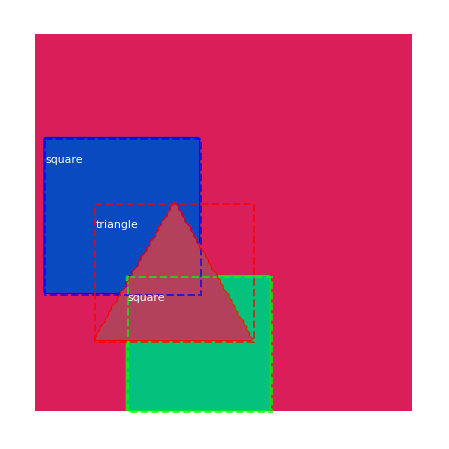

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    9.00000  max:  252.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -114.70000  max:  148.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


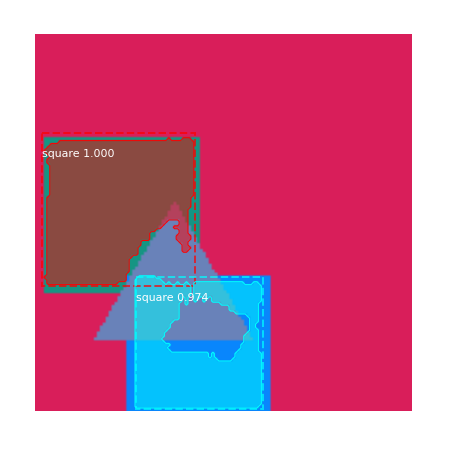

In [15]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

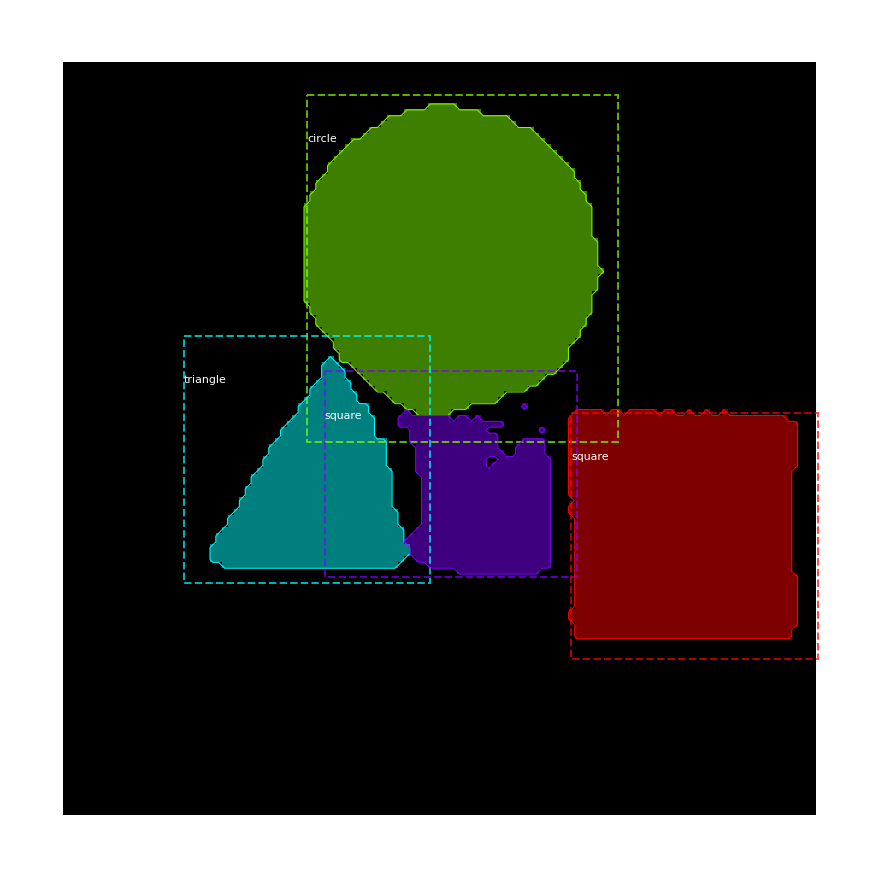

In [11]:
img = np.zeros(original_image.shape)

visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names)

## Evaluation

In [62]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
